Best threshold: 0.3500000000000001, Best F1-score: 0.832
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      1933
           1       0.78      0.90      0.83      1932

    accuracy                           0.82      3865
   macro avg       0.83      0.82      0.82      3865
weighted avg       0.83      0.82      0.82      3865



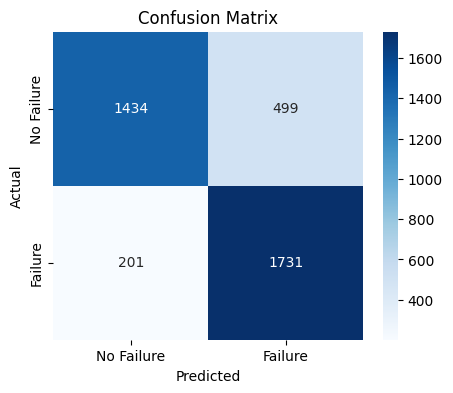

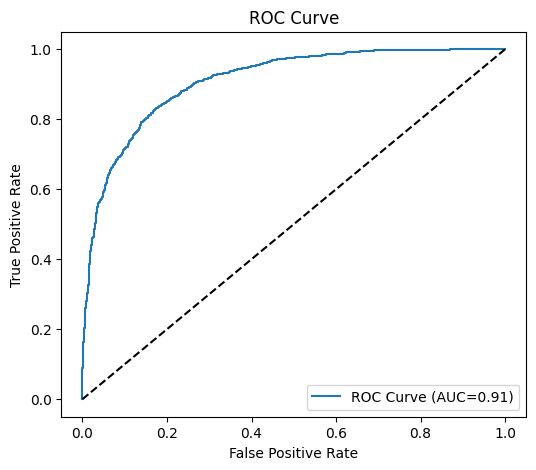

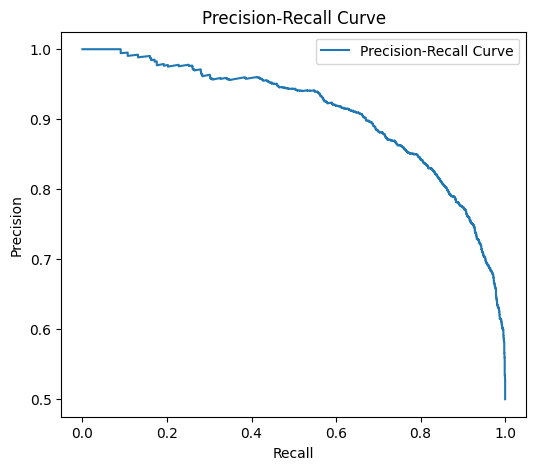

Top 10 features by absolute importance:
 Torque [Nm]                2.561406
Air temperature [K]        2.213375
Rotational speed [rpm]     1.820483
Process temperature [K]   -1.609903
Tool wear [min]            1.017911
Type_L                     0.392263
Type_M                     0.186106
dtype: float64
Example prediction probability of failure: 0.9965


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv('ai4i2020.csv')

# 2. Preprocessing
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = df['Machine failure']
X = pd.get_dummies(X, columns=['Type'], drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. SMOTE oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 5. Logistic Regression with cross-validation for hyperparameter tuning
log_reg_cv = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=2000,
    scoring='f1'
)
log_reg_cv.fit(X_train, y_train)

# 6. Predictions and threshold optimization
y_pred_prob = log_reg_cv.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred_temp = (y_pred_prob > t).astype(int)
    f1 = classification_report(y_test, y_pred_temp, output_dict=True)['1']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

# Apply best threshold
y_pred = (y_pred_prob > best_thresh).astype(int)

# 7. Evaluation
print(f"Best threshold: {best_thresh}, Best F1-score: {best_f1:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 8. Feature Importance
feature_importance = pd.Series(log_reg_cv.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print("Top 10 features by absolute importance:\n", feature_importance.head(10))

# Example prediction
example = X_test[0].reshape(1, -1)
pred_example = log_reg_cv.predict_proba(example)[0][1]
print(f"Example prediction probability of failure: {pred_example:.4f}")